In [2]:
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(sys.executable)
print(tf.__version__)

/workspaces/mlzoomcamp-capstone-project/.venv/bin/python3
2.20.0


In [3]:
# Make runs deterministic-ish
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# CPU only (Codespaces)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

IMG_SIZE = 160
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
ds_full = tfds.load(
    "cats_vs_dogs",
    split="train",
    as_supervised=True,
    shuffle_files=True,
)

n = tf.data.experimental.cardinality(ds_full).numpy()
if n <= 0:
    raise RuntimeError("Could not determine dataset size (cardinality).")

# 80/10/10 split
n_test = int(0.10 * n)
n_val = int(0.10 * n)
n_train = n - n_val - n_test

ds_train_raw = ds_full.take(n_train)
ds_val_raw = ds_full.skip(n_train).take(n_val)
ds_test_raw = ds_full.skip(n_train + n_val).take(n_test)

print("Total:", n)
print("Train:", n_train, "Val:", n_val, "Test:", n_test)


2026-01-13 04:17:38.164232: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Total: 23262
Train: 18610 Val: 2326 Test: 2326


In [7]:
LABELS = {0: "cat", 1: "dog"}

def show_batch(ds, rows=2, cols=6, title=None):
    plt.figure(figsize=(cols * 2.2, rows * 2.2))
    if title:
        plt.suptitle(title)
    for i, (img, label) in enumerate(ds.take(rows * cols)):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(LABELS[int(label.numpy())])
        plt.axis("off")
    plt.show()

2026-01-13 04:19:17.761144: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


Train (sampled): {0: 2552, 1: 2448}
Val (sampled): {0: 994, 1: 1006}


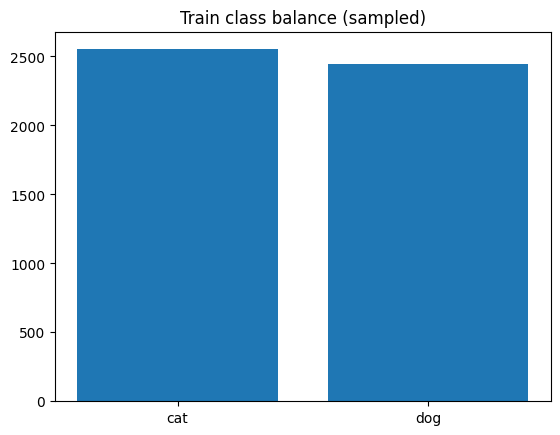

In [8]:
def count_labels(ds, limit=4000):
    counts = {0: 0, 1: 0}
    for i, (_, y) in enumerate(ds):
        counts[int(y.numpy())] += 1
        if i + 1 >= limit:
            break
    return counts

counts_train = count_labels(ds_train_raw, limit=5000)
counts_val = count_labels(ds_val_raw, limit=2000)

print("Train (sampled):", counts_train)
print("Val (sampled):", counts_val)

plt.bar([LABELS[0], LABELS[1]], [counts_train[0], counts_train[1]])
plt.title("Train class balance (sampled)")
plt.show()

2026-01-13 04:21:00.598853: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


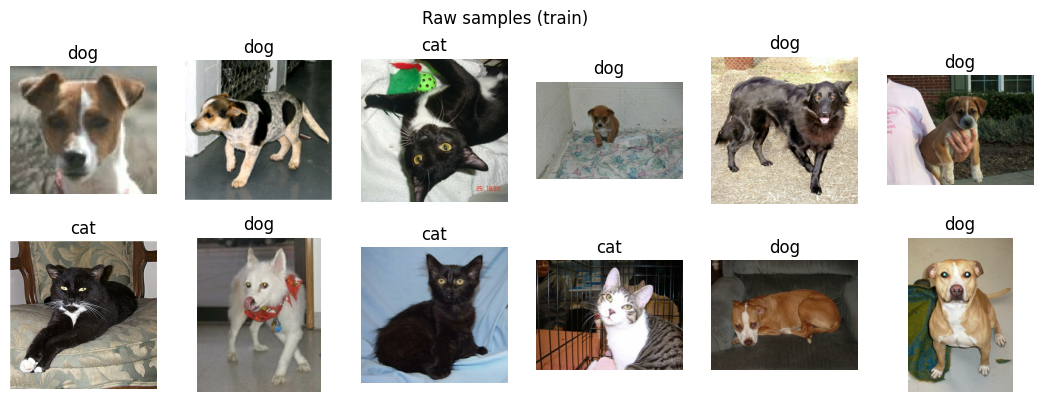

In [9]:
show_batch(ds_train_raw, title="Raw samples (train)")

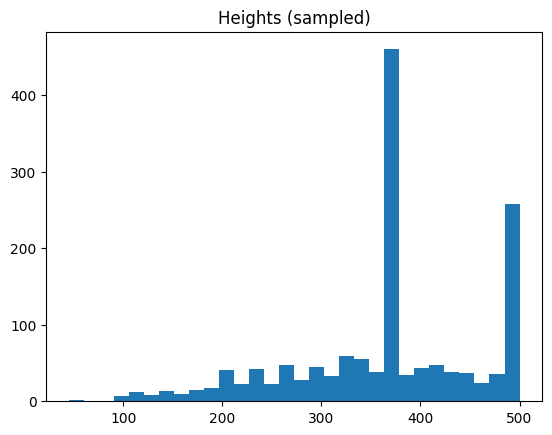

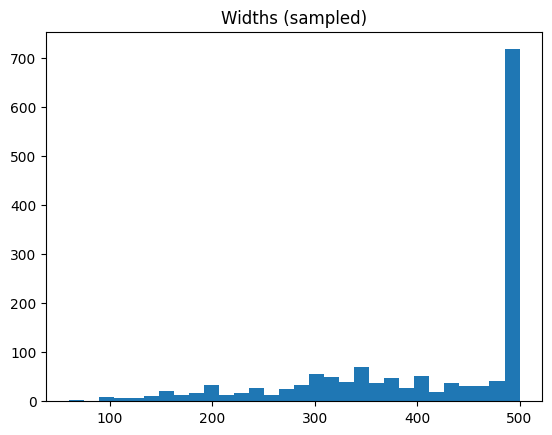

In [10]:
def collect_shapes(ds, limit=1500):
    h = []
    w = []
    for i, (img, _) in enumerate(ds):
        shape = img.shape
        h.append(int(shape[0]))
        w.append(int(shape[1]))
        if i + 1 >= limit:
            break
    return np.array(h), np.array(w)

h, w = collect_shapes(ds_train_raw, limit=1500)

plt.hist(h, bins=30)
plt.title("Heights (sampled)")
plt.show()

plt.hist(w, bins=30)
plt.title("Widths (sampled)")
plt.show()


In [11]:
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.float32)
    return image, label

# Simple augmentation (kept modest)
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
])

def preprocess_with_aug(image, label):
    image, label = preprocess(image, label)
    image = augment(image, training=True)
    return image, label


In [13]:
def make_ds(ds_raw, batch_size, training=False, with_aug=False):
    if training:
        if with_aug:
            ds = ds_raw.map(preprocess_with_aug, num_parallel_calls=AUTOTUNE)
        else:
            ds = ds_raw.map(preprocess, num_parallel_calls=AUTOTUNE)

        ds = ds.shuffle(2000, seed=SEED, reshuffle_each_iteration=True)
    else:
        ds = ds_raw.map(preprocess, num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

BS_BASELINE = 8
BS_MOBILENET = 8  # if you OOM, set to 8

train_base = make_ds(ds_train_raw, BS_BASELINE, training=True, with_aug=True)
val_base = make_ds(ds_val_raw, BS_BASELINE, training=False)
test_base = make_ds(ds_test_raw, BS_BASELINE, training=False)

train_mnet = make_ds(ds_train_raw, BS_MOBILENET, training=True, with_aug=True)
val_mnet = make_ds(ds_val_raw, BS_MOBILENET, training=False)
test_mnet = make_ds(ds_test_raw, BS_MOBILENET, training=False)

In [14]:
def build_baseline_cnn(img_size=160, lr=1e-3, dropout=0.3):
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )
    return model

baseline = build_baseline_cnn(img_size=IMG_SIZE, lr=1e-3, dropout=0.3)
baseline.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=2,
        restore_best_weights=True,
    )
]

history_baseline = baseline.fit(
    train_base,
    validation_data=val_base,
    epochs=1,
    callbacks=callbacks,
    verbose=1,
)

2026-01-13 04:22:44.959437: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25563136 exceeds 10% of free system memory.


   1/2327 ━━━━━━━━━━━━━━━━━━━━ 4:27:50 7s/step - accuracy: 0.5000 - auc: 0.5000 - loss: 0.6843

2026-01-13 04:22:45.578498: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 27320832 exceeds 10% of free system memory.
2026-01-13 04:22:45.655909: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25563136 exceeds 10% of free system memory.
2026-01-13 04:22:45.698240: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 25563136 exceeds 10% of free system memory.


   2/2327 ━━━━━━━━━━━━━━━━━━━━ 10:28 270ms/step - accuracy: 0.5625 - auc: 0.5104 - loss: 0.6682

2026-01-13 04:22:45.859887: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 27320832 exceeds 10% of free system memory.


2327/2327 ━━━━━━━━━━━━━━━━━━━━ 544s 231ms/step - accuracy: 0.5756 - auc: 0.6100 - loss: 0.6733 - val_accuracy: 0.6586 - val_auc: 0.7127 - val_loss: 0.6413


In [16]:
def eval_model(model, ds):
    return model.evaluate(ds, verbose=0)

def get_preds(model, ds):
    y_true = []
    y_pred = []
    for x, y in ds:
        p = model.predict(x, verbose=0).reshape(-1)
        y_true.append(y.numpy().reshape(-1))
        y_pred.append(p)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred

baseline_metrics = eval_model(baseline, test_base)
print("Baseline test metrics:", dict(zip(baseline.metrics_names, baseline_metrics)))

y_true, y_prob = get_preds(baseline, test_base)
y_hat = (y_prob >= 0.5).astype(int)

cm = tf.math.confusion_matrix(y_true.astype(int), y_hat, num_classes=2).numpy()
cm

Baseline test metrics: {'loss': 0.6483931541442871, 'compile_metrics': 0.6513327360153198}


2026-01-13 04:33:54.013782: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([[762, 379],
       [440, 745]], dtype=int32)

In [17]:
def build_mobilenetv2(img_size=160, lr=1e-3, dropout=0.2):
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))

    base = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights="imagenet",
    )
    base.trainable = False

    x = base(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.AUC(name="auc"),
        ],
    )
    return model

mnet = build_mobilenetv2(img_size=IMG_SIZE, lr=1e-3, dropout=0.2)
mnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=2,
        restore_best_weights=True,
    )
]

history_mnet = mnet.fit(
    train_mnet,
    validation_data=val_mnet,
    epochs=1,
    callbacks=callbacks,
    verbose=1,
)

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 255s 106ms/step - accuracy: 0.9562 - auc: 0.9916 - loss: 0.1134 - val_accuracy: 0.9768 - val_auc: 0.9976 - val_loss: 0.0617


In [19]:
mnet_metrics = eval_model(mnet, test_mnet)
print("MobileNetV2 test metrics:", dict(zip(mnet.metrics_names, mnet_metrics)))

MobileNetV2 test metrics: {'loss': 0.06137977913022041, 'compile_metrics': 0.9776440262794495}


In [20]:
results = [
    {"model": "baseline_cnn", "test_loss": baseline_metrics[0], "test_accuracy": baseline_metrics[1], "test_auc": baseline_metrics[2]},
    {"model": "mobilenetv2_tl", "test_loss": mnet_metrics[0], "test_accuracy": mnet_metrics[1], "test_auc": mnet_metrics[2]},
]

results

[{'model': 'baseline_cnn',
  'test_loss': 0.6483931541442871,
  'test_accuracy': 0.6513327360153198,
  'test_auc': 0.7003302574157715},
 {'model': 'mobilenetv2_tl',
  'test_loss': 0.06137977913022041,
  'test_accuracy': 0.9776440262794495,
  'test_auc': 0.9974750876426697}]

In [21]:
# MobileNetV2 is the final model because it performs better
# while training faster / more stable on CPU with transfer learning.

FINAL_MODEL = "mobilenetv2_tl"
print("Final model:", FINAL_MODEL)

# Optional: save the MobileNet model from notebook (separate from train.py)
# mnet.save("../models/cats_dogs.keras")

Final model: mobilenetv2_tl
